In [18]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats


In [11]:
from esmvalcore.dataset import Dataset

In [12]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [13]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [14]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [15]:
def prepoc1(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12) # get DEC
    return cube

def prepoc2(cube):
    pac_region = {"start_longitude": 140., "end_longitude": 260., "start_latitude": -1., "end_latitude": 1.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **pac_region)
    cube = anomalies(cube,period='monthly')
    cube = extract_month(cube,12) # get DEC
    cube = axis_statistics(cube,axis='y', operator='mean')
    return cube

In [16]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}


In [19]:
model_nino34 = model_datasets_prep1["ACCESS-ESM1-5"].data
model_ssta = model_datasets_prep2["ACCESS-ESM1-5"].data
model_lon = model_datasets_prep2["ACCESS-ESM1-5"].coord('longitude').points

# Transpose ssta_data to match the shape required for linregress
model_ssta_transposed = model_ssta.T  # Shape becomes (120, 36)

# Initialize an array to store the slope values for each spatial point
model_slope = np.zeros(model_ssta_transposed.shape[0])  # Length will be 120

# Loop over the 120 spatial points (after transpose, each row is a time series)
for i in range(model_ssta_transposed.shape[0]):
    # Perform linear regression between the transposed data and nino34_data
    model_slope[i], model_intercept, model_r_value, model_p_value, model_std_err = scipy.stats.linregress(model_ssta_transposed[i], model_nino34)


In [20]:
obs_nino34 = obs_datasets_prep1["HadISST"].data
obs_ssta = obs_datasets_prep2["HadISST"].data
obs_lon = obs_datasets_prep2["HadISST"].coord('longitude').points

# Transpose ssta_data to match the shape required for linregress
obs_ssta_transposed = obs_ssta.T  # Shape becomes (120, 36)

# Initialize an array to store the slope values for each spatial point
obs_slope = np.zeros(obs_ssta_transposed.shape[0])  # Length will be 120

# Loop over the 120 spatial points (after transpose, each row is a time series)
for i in range(obs_ssta_transposed.shape[0]):
    # Perform linear regression between the transposed data and nino34_data
    obs_slope[i], obs_intercept, obs_r_value, obs_p_value, obs_std_err = scipy.stats.linregress(obs_ssta_transposed[i], obs_nino34)


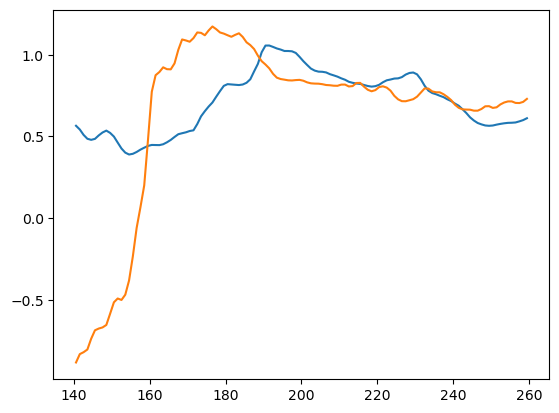

In [21]:
# Now slope will be an array of length 120
plt.plot(model_lon, model_slope)
plt.plot(obs_lon, obs_slope)